In [1]:
import sys
import os
os.chdir("/athena/marchionnilab/scratch/lab_data/Mohamed/pca_TME")
#sys.setrecursionlimit(22000)
from pathlib import Path
import scanpy as sc
from matplotlib.pyplot import ion
from scutils.figures.base import basics
from scutils.figures.prostate import annotate_cell_types_prostate
from scutils.qc import PreprocessRNA
from mousipy import translate
import pandas as pd
import scipy.sparse as sp
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad
sc.settings.figdir = ''

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
sc._settings.ScanpyConfig(figdir = 'figs_new', plot_suffix = '', n_jobs = 20, max_memory = 100)
sc.set_figure_params(dpi_save = 300)

In [3]:
adata_mouse = sc.read_h5ad('outs/h5ads/fapcm_fibroblasts_v6_clean_regulons_5.h5ad', chunk_size=100000)
adata_mouse.obs['cluster'] = adata_mouse.obs['cluster'].astype('str')
adata_mouse.obs['cluster'].value_counts()

1      2541
0      1442
5       997
3       903
6       895
7       753
4       733
nan     406
2       310
Name: cluster, dtype: int64

In [4]:
len(adata_mouse.obs['endothelial'])

8980

In [5]:
adata_mouse

AnnData object with n_obs × n_vars = 8980 × 4000
    obs: 'batch', 'key', 'model', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'scrubletscores', 'scrubletdoublets', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'endothelial', 'fibroblast', 'myofibroblast', 'dendritic', 'cCDs', 'langherhans_like', 'b', 't_nk', 'myeloid', 'mast', 'luminal', 'basal', 'notluminal', 'macrophages', 'neuroendocrine', 'seminal_vesicle_basal', 'seminal_vesicle_luminal', 'seminal_vesicle_ionocyte', 'Regulon(Arid5a)', 'Regulon(Arid5b)', 'Regulon(Ascl1)', 'Regulon(Ascl2)', 'Regulon(Atf3)', 'Regulon(Bach1)', 'Regulon(Batf)', 'Regulon(Bcl3)', 'Regulon(Cebpa)', 'Regulon(Cebpb)', 'Regulon(Cebpd)', 'Regulon(Creb5)', 'Regulon(Crem)', 'Regulon(Dusp26)', 'Regulon(Egr1)', 'Regulon(Egr2)', 'Regulon(Egr3)', 'Regulon(Egr4)', 'Regulon(Eomes)', 'Regulon(Erg)', 'Regulon(Ets1)', '

In [6]:
# filter the na
adata_mouse = adata_mouse[adata_mouse.obs['cluster'] != 'nan', :]
adata_mouse.obs['cluster'].value_counts()

1    2541
0    1442
5     997
3     903
6     895
7     753
4     733
2     310
Name: cluster, dtype: int64

In [7]:
# save the normalized data (not z-scored) for cellchat
adata_mouse_raw = adata_mouse.copy()
adata_mouse_raw = adata_mouse_raw.raw.to_adata()
adata_mouse_raw.X = sp.csr_matrix.todense(adata_mouse_raw.X)
adata_mouse_raw.X = adata_mouse_raw.to_df()
adata_mouse_raw.write('outs/forCellChat/adata_mouse_norm.h5ad')

# Process the human data using ingest

In [6]:
# load the human data
adata_human = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons.h5ad', chunk_size=100000)

In [7]:
adata_human.obs.erg.value_counts()

positive    6990
negative    1638
Name: erg, dtype: int64

In [8]:
# change the var_names to match mouse gene symbols
adata_human.var_names = [gene.title() for gene in adata_human.var_names]

# subset also the adata_human.raw
tempAdata = adata_human.raw.to_adata()
tempAdata.var_names = [gene.title() for gene in tempAdata.var_names]
adata_human.raw = tempAdata

In [39]:
adata_human.var_names
adata_human.raw.var_names

Index(['A1Bg', 'A1Bg-As1', 'A1Cf', 'A2M', 'A2M-As1', 'A2Ml1', 'A2Ml1-As1',
       'A2Ml1-As2', 'A3Galt2', 'A4Galt',
       ...
       'Zw10', 'Zwilch', 'Zwint', 'Zxda', 'Zxdb', 'Zxdc', 'Zyg11A', 'Zyg11B',
       'Zyx', 'Zzef1'],
      dtype='object', length=30631)

In [40]:
# find common genes
var_names = adata_mouse.var_names.intersection(adata_human.var_names)
len(var_names)

1342

In [41]:
# subset
adata_mouse = adata_mouse[:, var_names]
adata_human = adata_human[:, var_names]


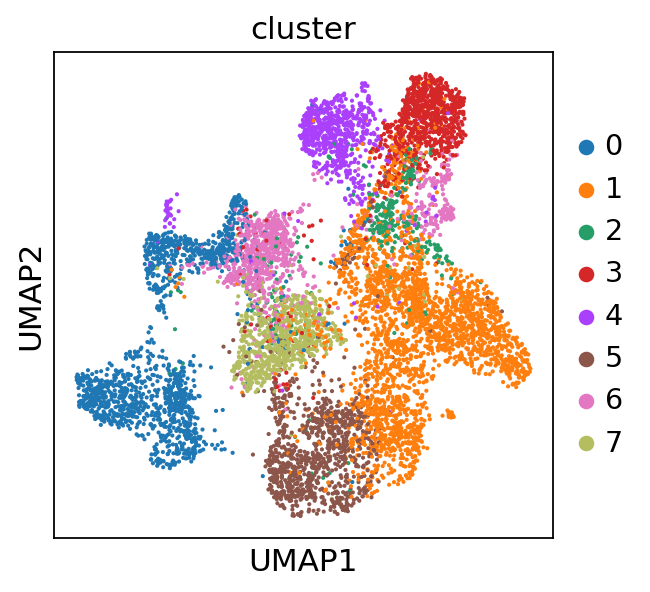

In [42]:
# recompute the neighbors for the adata_mouse (ref dataset)
sc.pp.pca(adata_mouse)
sc.pp.neighbors(adata_mouse)
sc.tl.umap(adata_mouse)
sc.pl.umap(adata_mouse, color='cluster', save = 'mouse_umap.png')

In [43]:
# mapping the clusters from mouse to human using ingest
sc.tl.ingest(adata_human, adata_mouse, obs='cluster')

In [44]:
adata_human

AnnData object with n_obs × n_vars = 8628 × 1342
    obs: 'key', 'condition', 'tn', 'case', 'erg', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'scrubletscores', 'scrubletdoublets', 'leiden', '_scvi_batch', '_scvi_labels', 'endothelial', 'fibroblast', 'myofibroblast', 'dendritic', 'pDC', 'cCDs', 'langherhans_like', 'b', 't_nk', 'myeloid', 'mast', 'luminal', 'basal', 'notbasal', 'macrophages', 'neuroendocrine', 'seminal_vesicle_basal', 'seminal_vesicle_luminal', 'seminal_vesicle_ionocyte', 'Regulon(ARID5B)', 'Regulon(ATF3)', 'Regulon(BCL11A)', 'Regulon(BHLHE22)', 'Regulon(CDX1)', 'Regulon(CEBPB)', 'Regulon(CEBPD)', 'Regulon(CREB5)', 'Regulon(CREM)', 'Regulon(DDIT3)', 'Regulon(E2F2)', 'Regulon(E2F8)', 'Regulon(EBF1)', 'Regulon(EGR1)', 'Regulon(EGR3)', 'Regulon(EOMES)', 'Regulon(ERG)', 'Regulon(FOS)', 'Regulon(FOSB)', 'Regulon(FOSL1)', 'Regulon(FOXA1)', 'Regulon(FOXP3)', 'Regulon(FOXQ1)', 'Regulon(GATA2)', 'Regulon(GLIS2)', 'Regulon(HOXB13)', 'Regulon(IRF4)', 'R

In [45]:
# divide the human data into ERG pos and neg
adata_human_ERGpos = adata_human[adata_human.obs.erg=='positive']
adata_human_ERGneg = adata_human[adata_human.obs.erg=='negative']

In [46]:
# Number of cells in each cluster: mouse vs human 
print(adata_mouse.obs['cluster'].value_counts())
print(adata_human.obs['cluster'].value_counts())
print(adata_human_ERGpos.obs['cluster'].value_counts())
print(adata_human_ERGneg.obs['cluster'].value_counts())

1    2541
0    1442
5     997
3     903
6     895
7     753
4     733
2     310
Name: cluster, dtype: int64
6    3976
1    2558
0    1151
7     514
3     152
4     150
2      68
5      59
Name: cluster, dtype: int64
6    3381
1    1925
0     924
7     434
3     135
4      91
2      50
5      50
Name: cluster, dtype: int64
1    633
6    595
0    227
7     80
4     59
2     18
3     17
5      9
Name: cluster, dtype: int64


In [47]:
adata_human.uns['cluster_colors'] = adata_mouse.uns['cluster_colors']  # fix colors

# Ingest using adata_mouse_terg as reference and adata_human_ERGpos as the target

In [48]:
# mouse T-erg model
print(adata_mouse.obs.key.value_counts())
adata_mouse_terg = adata_mouse[adata_mouse.obs.key=='terg']
adata_mouse_nonterg = adata_mouse[adata_mouse.obs.key!='terg']
print(adata_mouse_terg.obs.cluster.value_counts())
print(adata_mouse_nonterg.obs.cluster.value_counts())

mycn          4510
fvbn          1087
terg          1085
himyc          864
129b6_pten     371
b6             287
129b6_mycn     155
129b6          130
pten            85
Name: key, dtype: int64
3    448
1    263
0    187
4     98
2     66
6     22
7      1
Name: cluster, dtype: int64
1    2278
0    1255
5     997
6     873
7     752
4     635
3     455
2     244
Name: cluster, dtype: int64


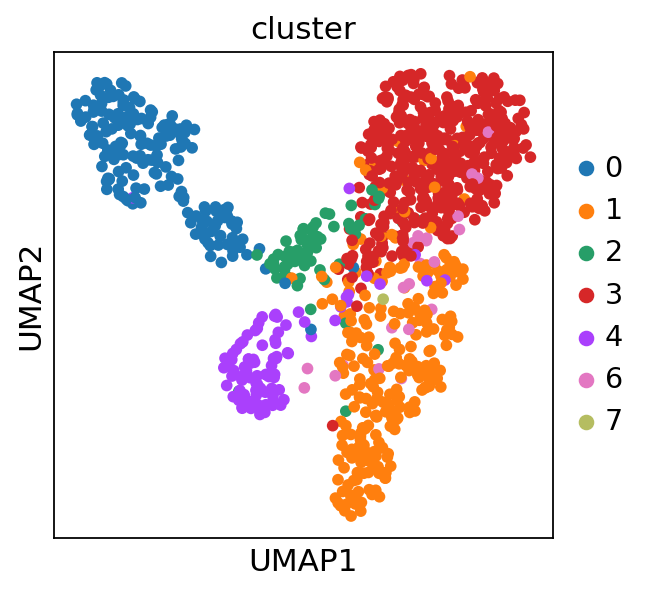

In [77]:
# recompute the neighbors for the adata_mouse_terg (ref dataset)
sc.pp.pca(adata_mouse_terg)
sc.pp.neighbors(adata_mouse_terg)
sc.tl.umap(adata_mouse_terg)
sc.pl.umap(adata_mouse_terg, color='cluster', save = 'mouse_terg_umap.png')

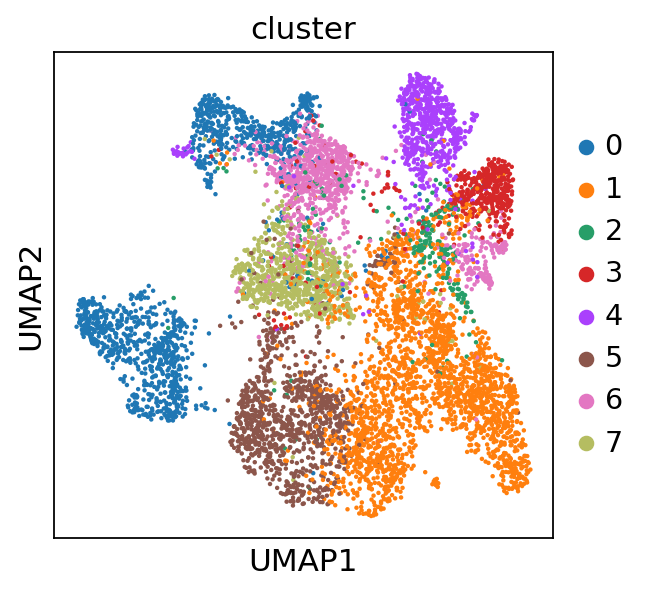

In [50]:
# recompute the neighbors for the adata_mouse_nonterg (ref dataset)
sc.pp.pca(adata_mouse_nonterg)
sc.pp.neighbors(adata_mouse_nonterg)
sc.tl.umap(adata_mouse_nonterg)
sc.pl.umap(adata_mouse_nonterg, color='cluster', save = 'mouse_nonterg_umap.png')

In [51]:
# Ingest using adata_mouse_terg as reference and adata_human_ERGpos as the target
sc.tl.ingest(adata_human_ERGpos, adata_mouse_terg, obs='cluster')

In [52]:
# Ingest using adata_mouse_nonterg as reference and adata_human_ERGneg as the target
sc.tl.ingest(adata_human_ERGneg, adata_mouse_nonterg, obs='cluster')

In [53]:
print(len(adata_mouse_terg.obs_names))
print(len(adata_human_ERGpos.obs_names))

1085
6990


In [54]:
# cell frequency in each cluster
print(adata_mouse_terg.obs.cluster.value_counts())
print(adata_human_ERGpos.obs.cluster.value_counts())

3    448
1    263
0    187
4     98
2     66
6     22
7      1
Name: cluster, dtype: int64
3    5522
1     965
0     475
2      25
4       3
6       0
7       0
Name: cluster, dtype: int64


In [55]:
# cell frequency in each cluster
print(adata_mouse_nonterg.obs.cluster.value_counts())
print(adata_human_ERGneg.obs.cluster.value_counts())

1    2278
0    1255
5     997
6     873
7     752
4     635
3     455
2     244
Name: cluster, dtype: int64
6    789
1    511
0    132
7    113
4     60
3     17
5     16
2      0
Name: cluster, dtype: int64


In [56]:
# concat adata_human_ERGpos and adata_human_ERGneg into a new adata_human
adata_human_list = [adata_human_ERGpos, adata_human_ERGneg]
adata_human_new = ad.concat(adata_human_list, label = 'erg', join = 'outer')

In [57]:
adata_human_new

AnnData object with n_obs × n_vars = 8628 × 1342
    obs: 'key', 'condition', 'tn', 'case', 'erg', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'scrubletscores', 'scrubletdoublets', 'leiden', '_scvi_batch', '_scvi_labels', 'endothelial', 'fibroblast', 'myofibroblast', 'dendritic', 'pDC', 'cCDs', 'langherhans_like', 'b', 't_nk', 'myeloid', 'mast', 'luminal', 'basal', 'notbasal', 'macrophages', 'neuroendocrine', 'seminal_vesicle_basal', 'seminal_vesicle_luminal', 'seminal_vesicle_ionocyte', 'Regulon(ARID5B)', 'Regulon(ATF3)', 'Regulon(BCL11A)', 'Regulon(BHLHE22)', 'Regulon(CDX1)', 'Regulon(CEBPB)', 'Regulon(CEBPD)', 'Regulon(CREB5)', 'Regulon(CREM)', 'Regulon(DDIT3)', 'Regulon(E2F2)', 'Regulon(E2F8)', 'Regulon(EBF1)', 'Regulon(EGR1)', 'Regulon(EGR3)', 'Regulon(EOMES)', 'Regulon(ERG)', 'Regulon(FOS)', 'Regulon(FOSB)', 'Regulon(FOSL1)', 'Regulon(FOXA1)', 'Regulon(FOXP3)', 'Regulon(FOXQ1)', 'Regulon(GATA2)', 'Regulon(GLIS2)', 'Regulon(HOXB13)', 'Regulon(IRF4)', 'R

In [82]:
print(adata_human_new.obs.cluster.value_counts())

3    5539
1    1476
6     789
0     607
7     113
4      63
2      25
5      16
Name: cluster, dtype: int64


# save the human count matrix with the cluster info

In [59]:
adata_human.write('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.h5ad')
adata_human_new.write('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot_new.h5ad')
adata_human_ERGpos.write('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_ERGpos_annot.h5ad')

# load the annot human data

In [8]:
adata_human = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot.h5ad', chunk_size=100000)
adata_human_new = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_annot_new.h5ad', chunk_size=100000)
adata_human_ERGpos = sc.read_h5ad('outs_human/h5ads/erg_fibroblasts_scvi_v6_regulons_ERGpos_annot.h5ad', chunk_size=100000)

############

In [ ]:
sc.pl.umap(adata_mouse, color='cluster', save = 'mouse_umap.png')

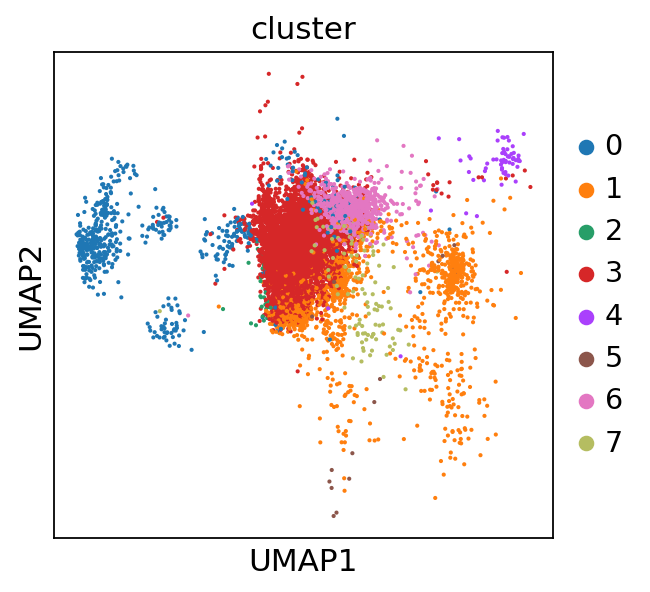

In [90]:
sc.pl.umap(adata_human_new, color='cluster', save = 'human_umap.png')

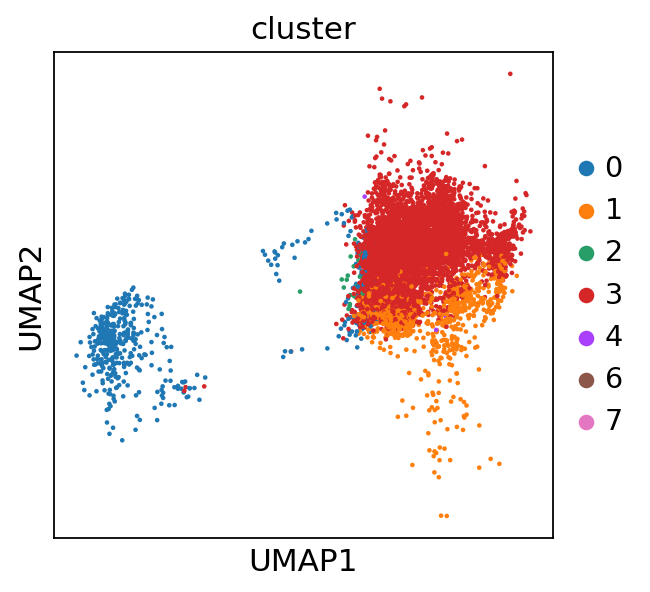

In [36]:
sc.pl.umap(adata_human_ERGpos, color='cluster', save = 'human_ERGpos_umap.png')

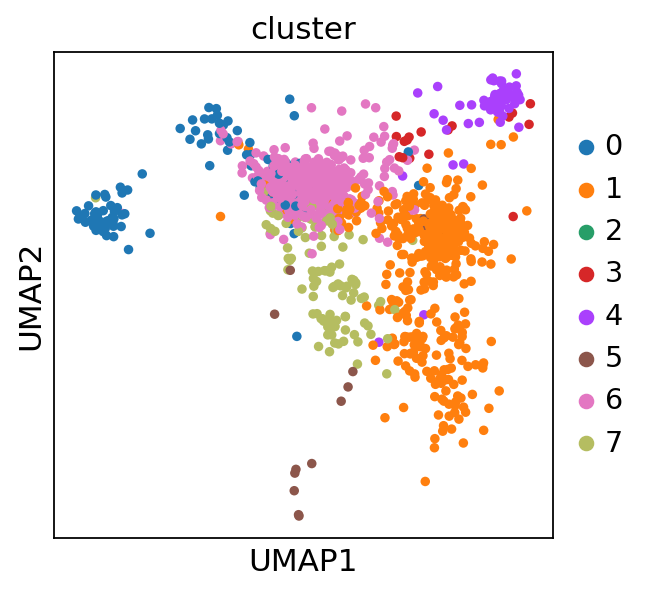

In [37]:
sc.pl.umap(adata_human_ERGneg, color='cluster', save = 'human_ERGneg_umap.png')

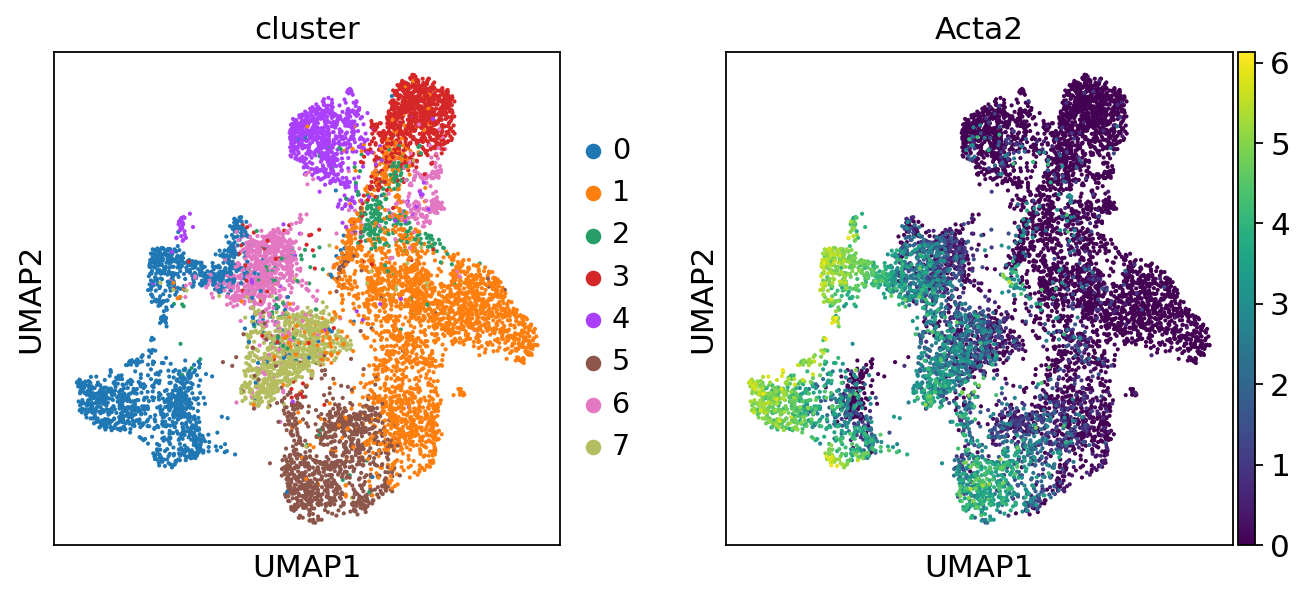

In [144]:
sc.pl.umap(adata_mouse, color=['cluster', 'Acta2'], save = 'mouse_ACTA2.png')

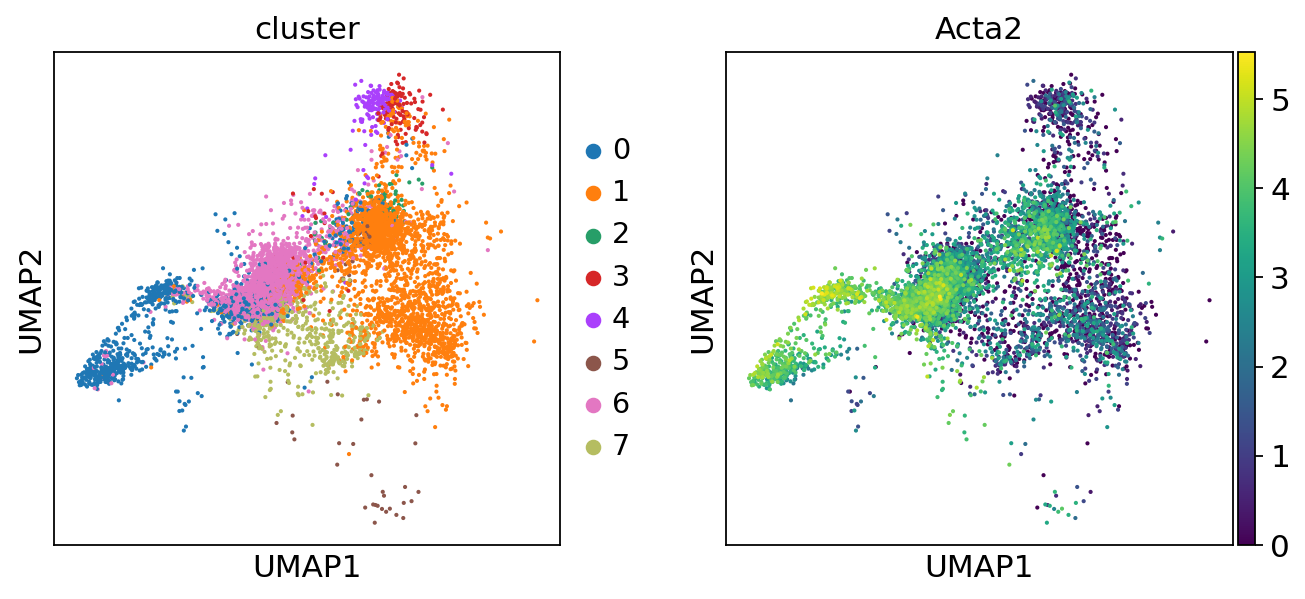

In [18]:
sc.pl.umap(adata_human, color=['cluster', 'Acta2'], save = 'human_ACTA2.png')

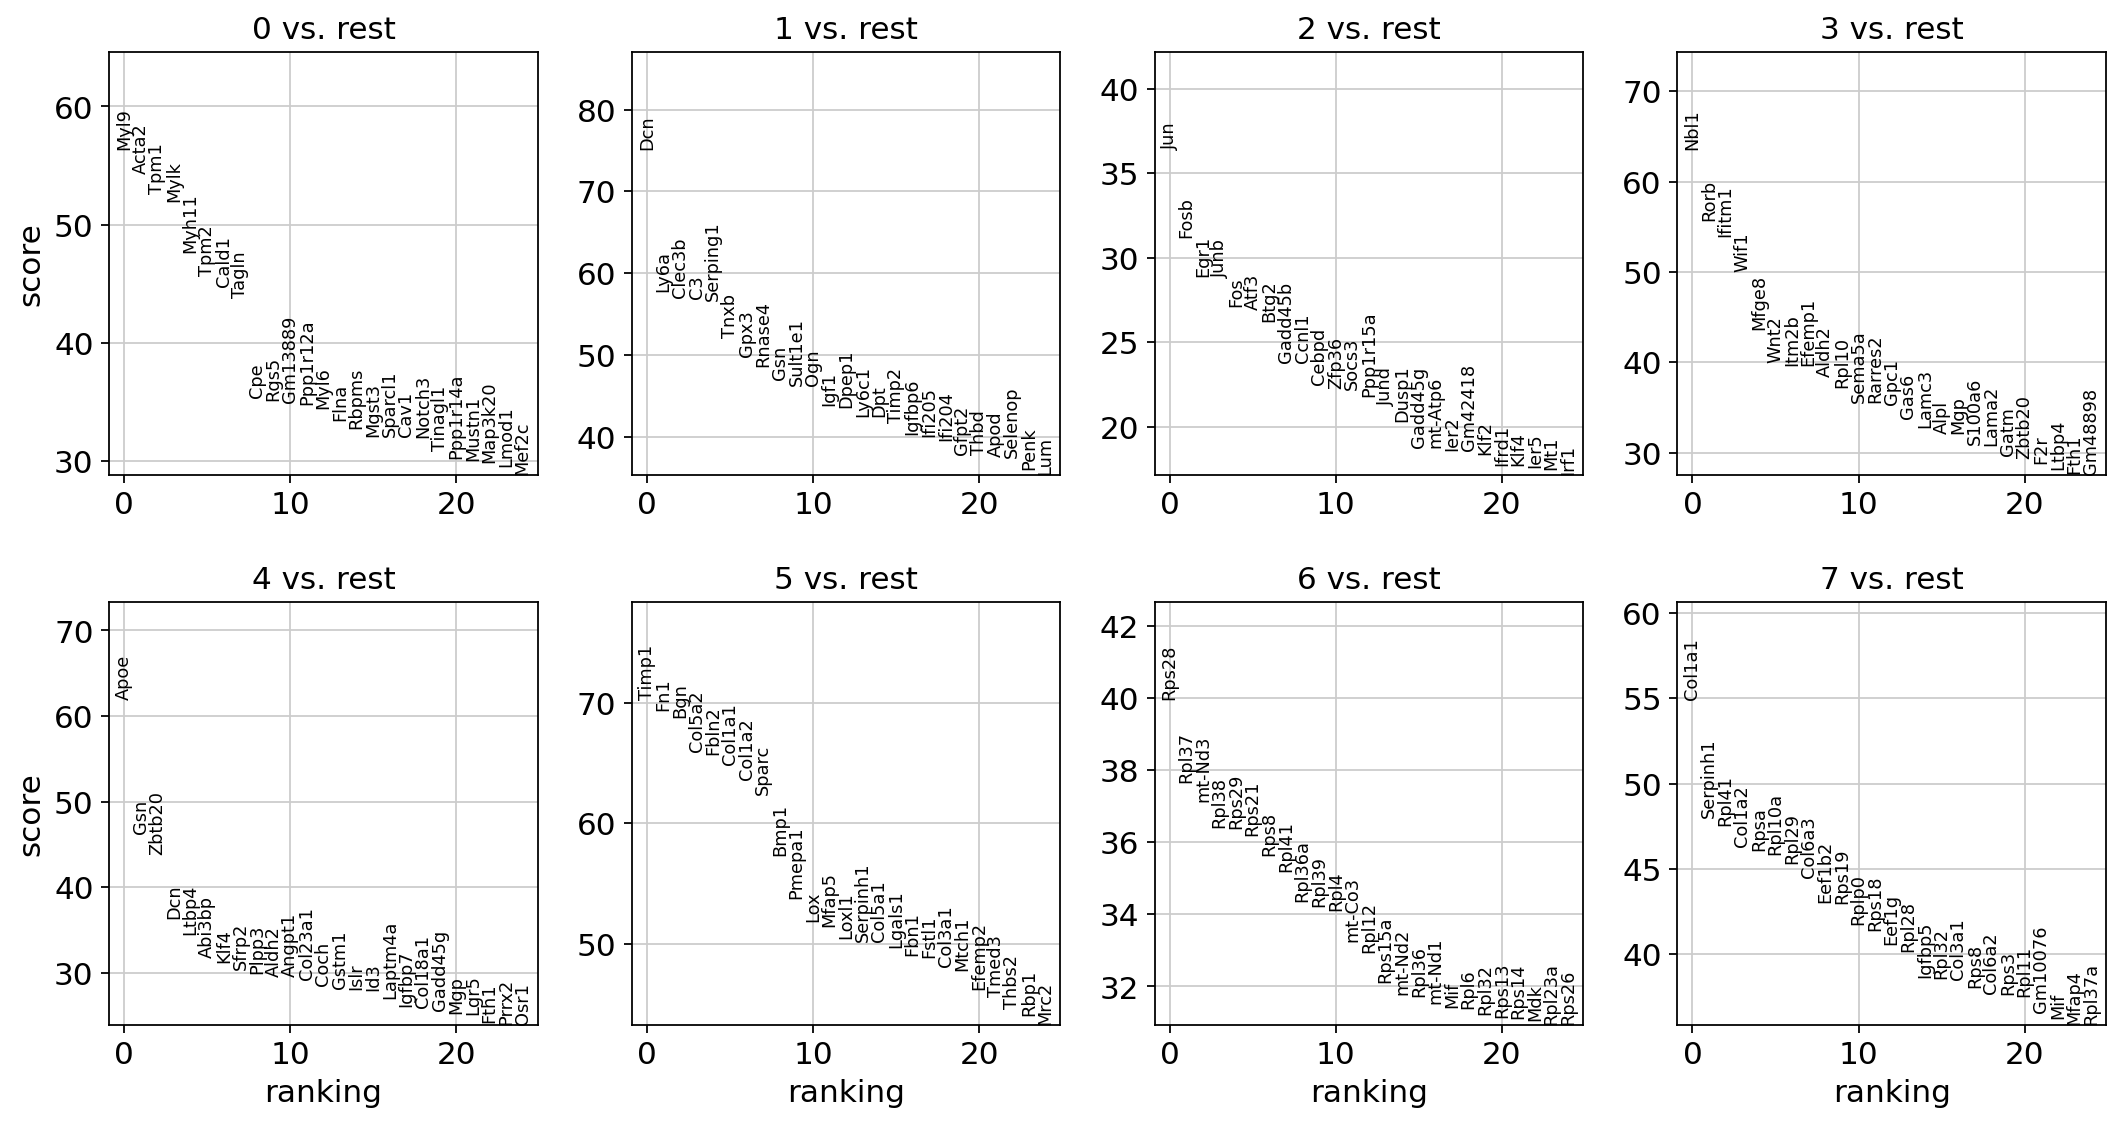

In [62]:
sc.tl.rank_genes_groups(adata_mouse, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata_mouse, n_genes=25, sharey=False, save = 'mouseMarkers.png')

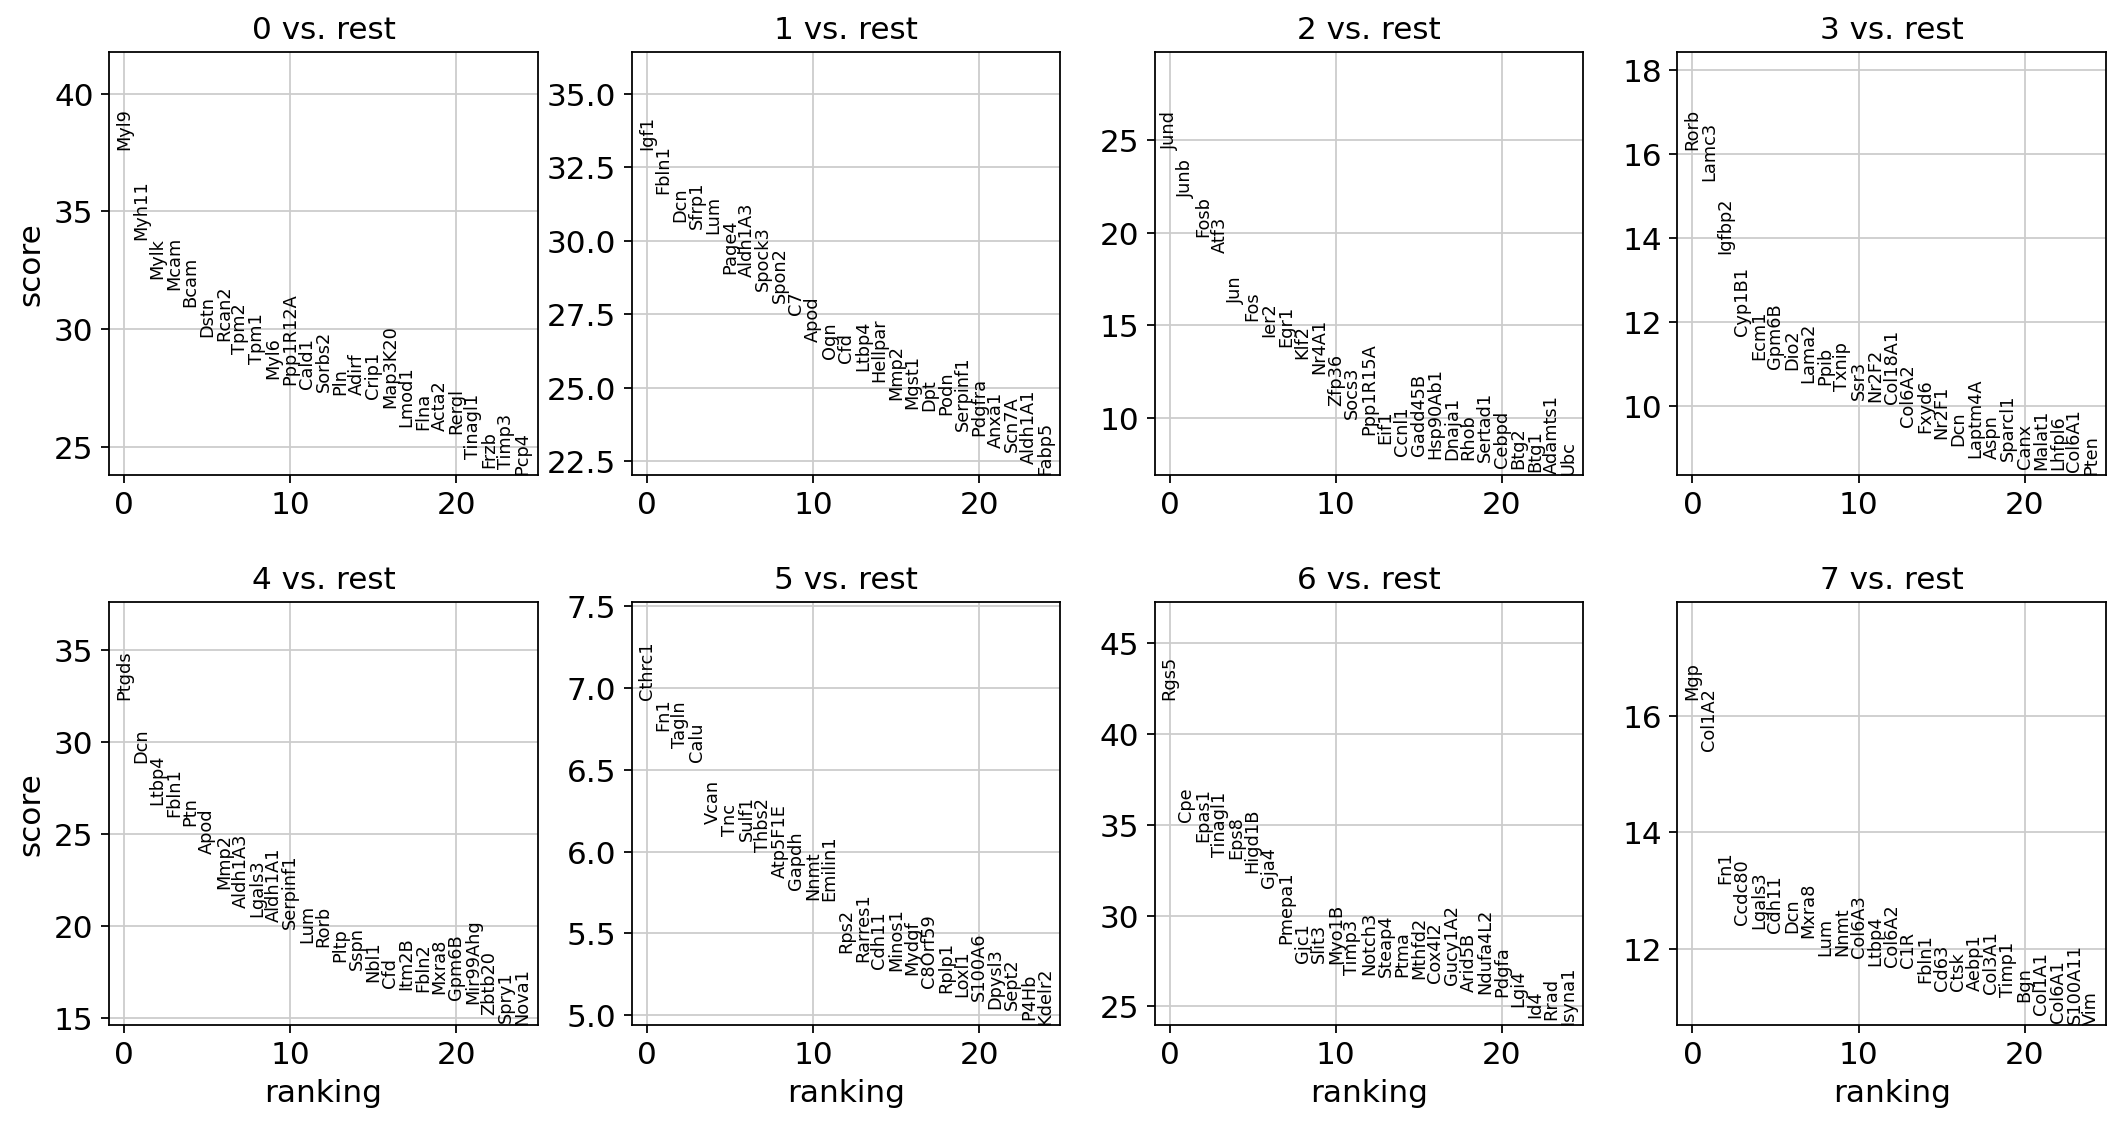

In [157]:
sc.tl.rank_genes_groups(adata_human, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata_human, n_genes=25, sharey=False, save = 'humanMarkers.png')

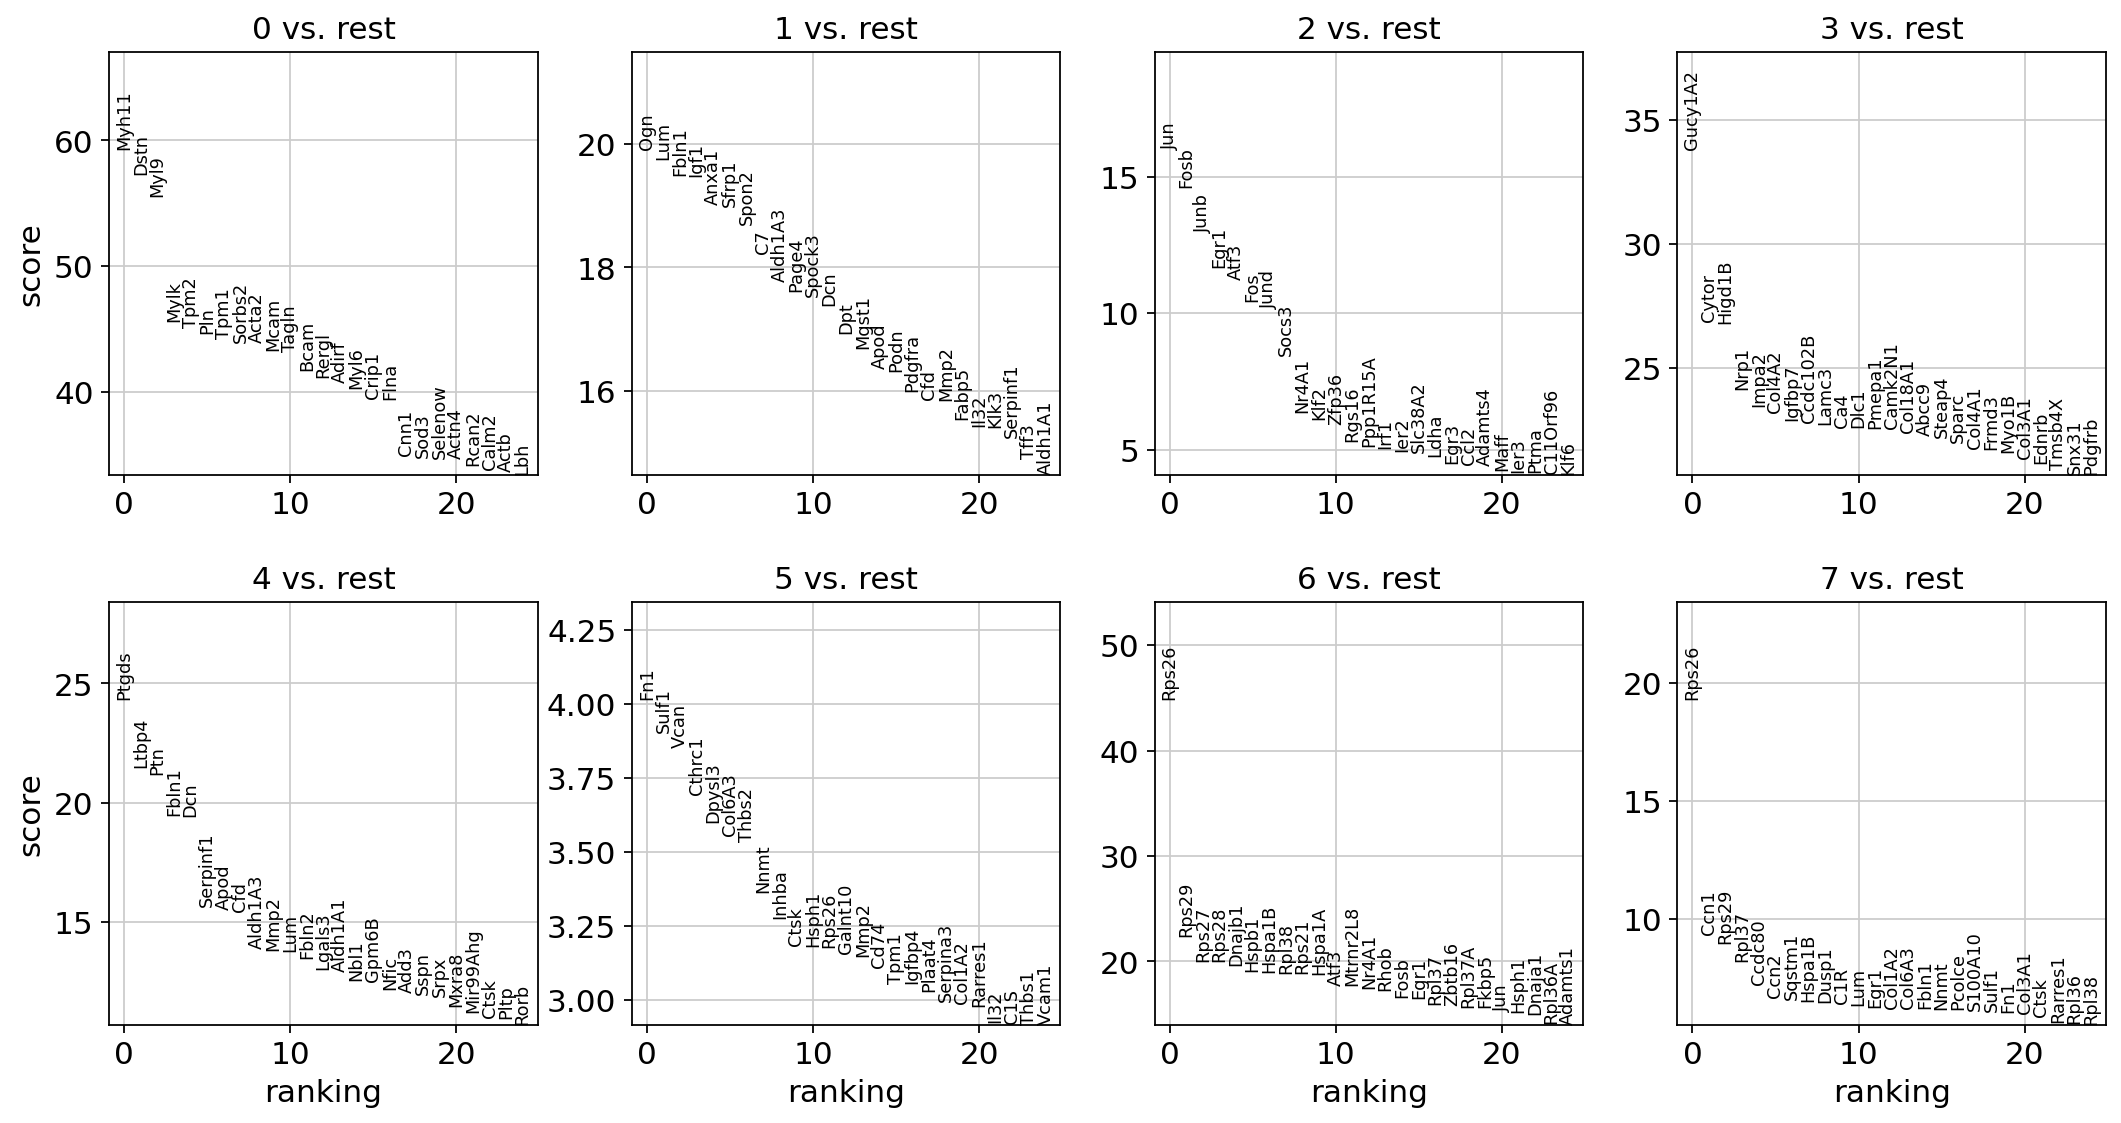

In [63]:
sc.tl.rank_genes_groups(adata_human_new, 'cluster', method='t-test')
sc.pl.rank_genes_groups(adata_human_new, n_genes=25, sharey=False, save = 'humanMarkers.png')

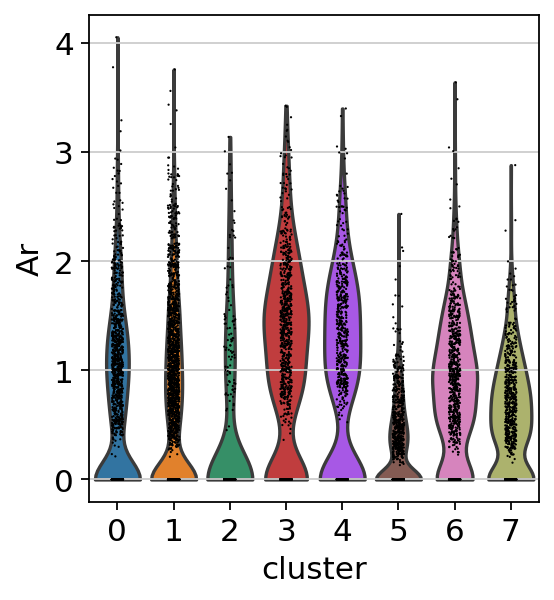

In [78]:
sc.pl.violin(adata_mouse, ['Ar'], groupby = 'cluster', save = 'AR_mouse.png')

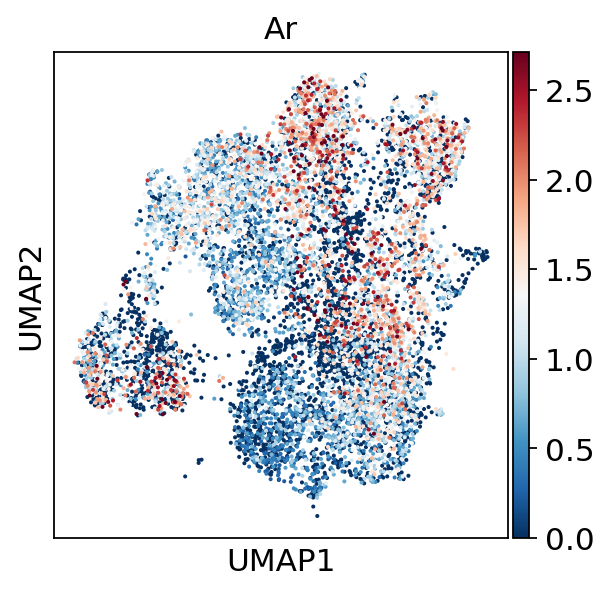

In [92]:
sc.pl.umap(adata_mouse, color='Ar', color_map = 'RdBu_r', vmin='p1', vmax='p99', save = '_Ar_mouse_all.png')

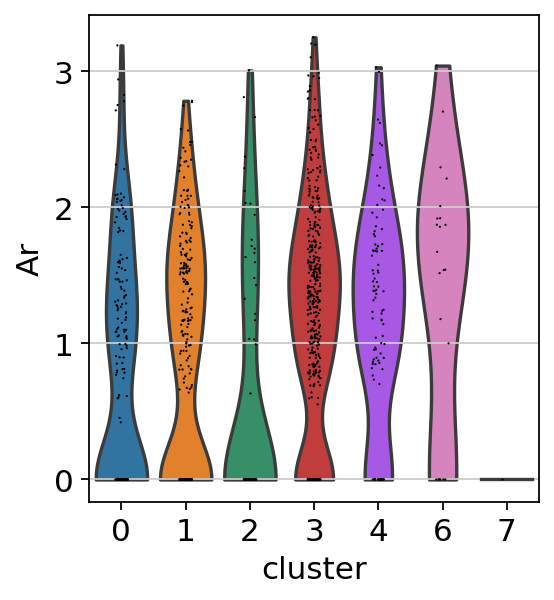

In [79]:
sc.pl.violin(adata_mouse_terg, ['Ar'], groupby = 'cluster', save = 'AR_mouse_terg.png')

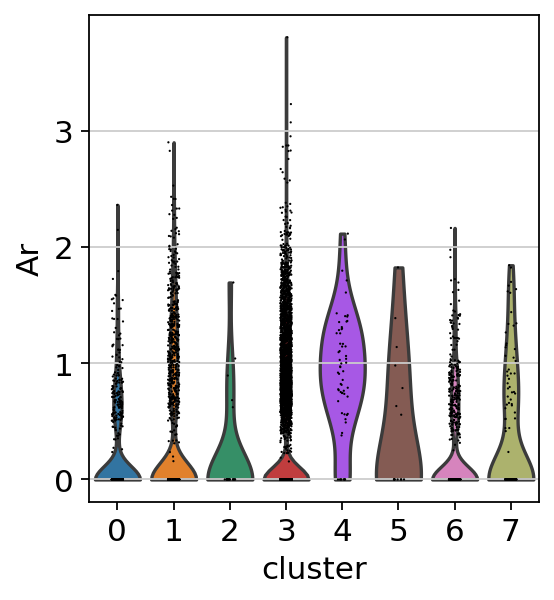

In [43]:
sc.pl.violin(adata_human_new, ['Ar'], groupby = 'cluster', save = 'AR_human.png')

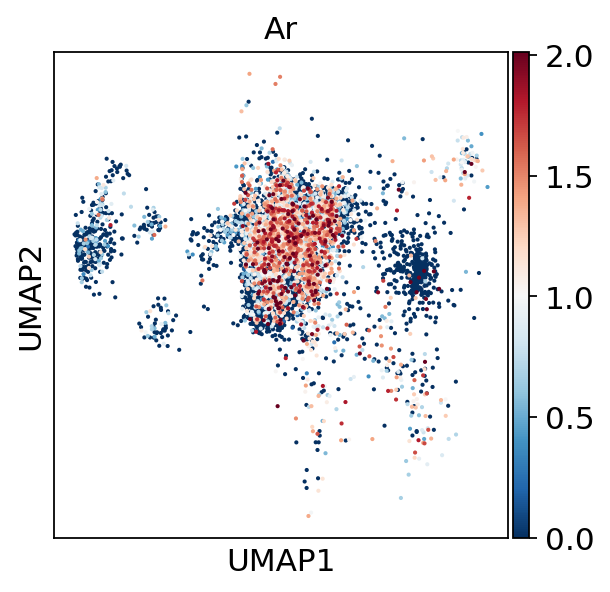

In [93]:
sc.pl.umap(adata_human_new, color=['Ar'], color_map = 'RdBu_r', vmin='p1', vmax='p99', save = '_Ar_human_all.png')

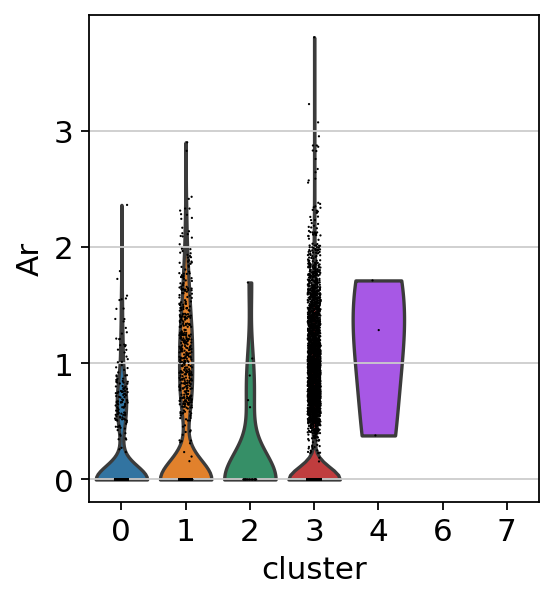

In [80]:
sc.pl.violin(adata_human_ERGpos, ['Ar'], groupby = 'cluster', save = 'AR_human_ERGpos.png')

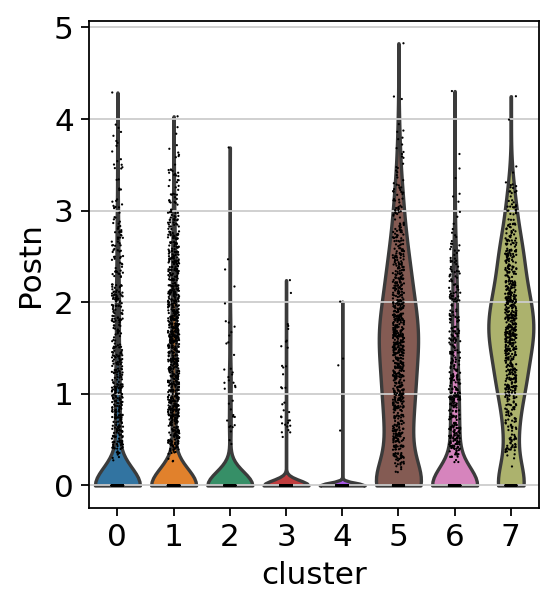

In [81]:
# violin for Periostin mouse
sc.pl.violin(adata_mouse, ['Postn'], groupby = 'cluster', save = 'Postn_mouse.png')

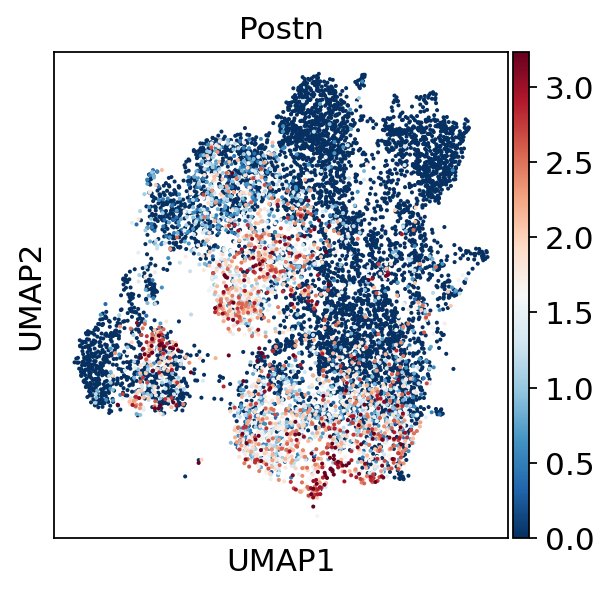

In [96]:
# umap for Periostin mouse
sc.pl.umap(adata_mouse, color= 'Postn', color_map = 'RdBu_r', vmin='p1', vmax='p99', save = '_Postn_mouse_all.png')

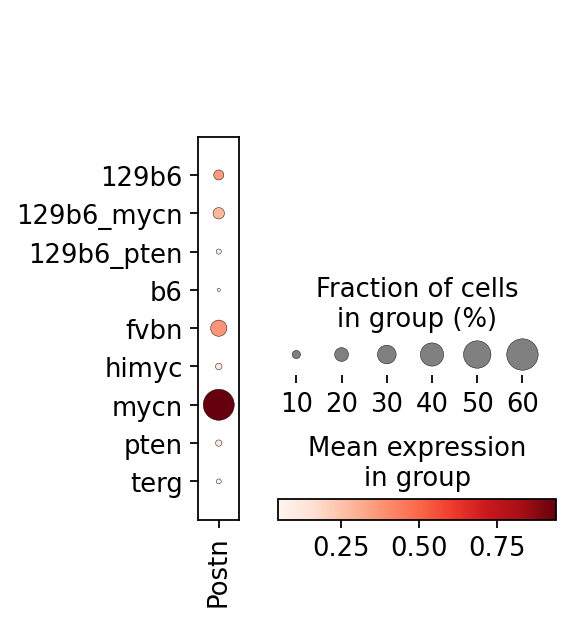

In [9]:
# dotplot for periostin per different mouse models
dp = sc.pl.DotPlot(adata_mouse, var_names = 'Postn', groupby = 'key', cmap = 'Reds')
dp.legend(width=2.5).savefig('dotplot_Postn_mouse.png')

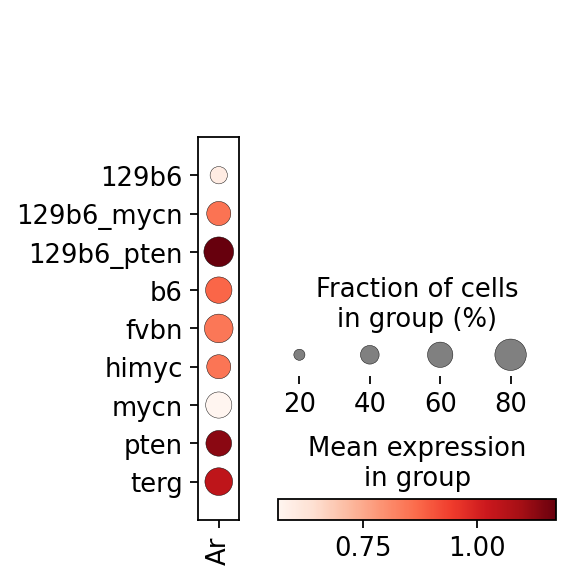

In [10]:
# dotplot for Ar per different mouse models
dp = sc.pl.DotPlot(adata_mouse, var_names = 'Ar', groupby = 'key', cmap = 'Reds')
dp.legend(width=2.5).savefig('dotplot_Ar_mouse.png')

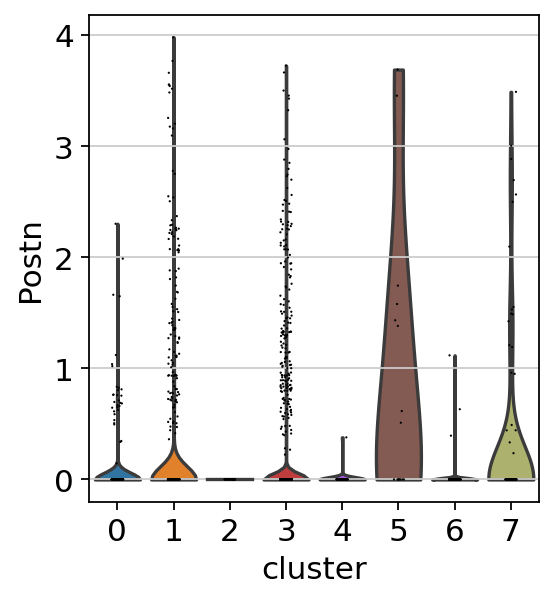

In [162]:
# violin for Periostin human
sc.pl.violin(adata_human_new, ['Postn'], groupby = 'cluster', save = 'Postn_human.png')

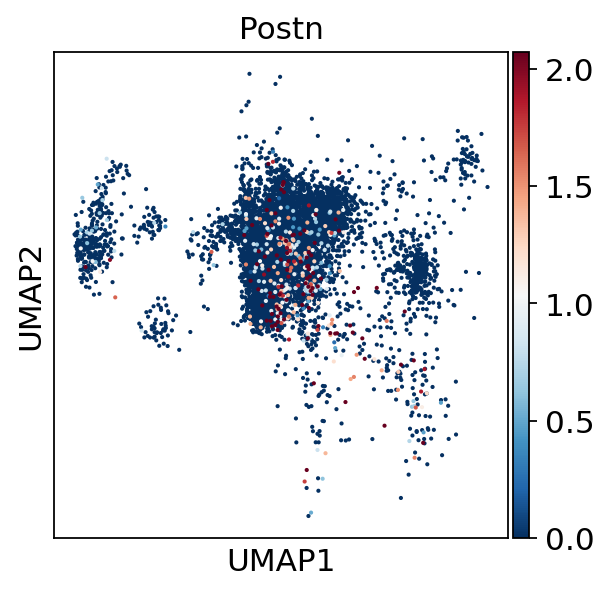

In [99]:
# umap for Periostin human
sc.pl.umap(adata_human_new, color='Postn', color_map = 'RdBu_r', vmin='p1', vmax='p99', save = '_Postn_human_all.png')

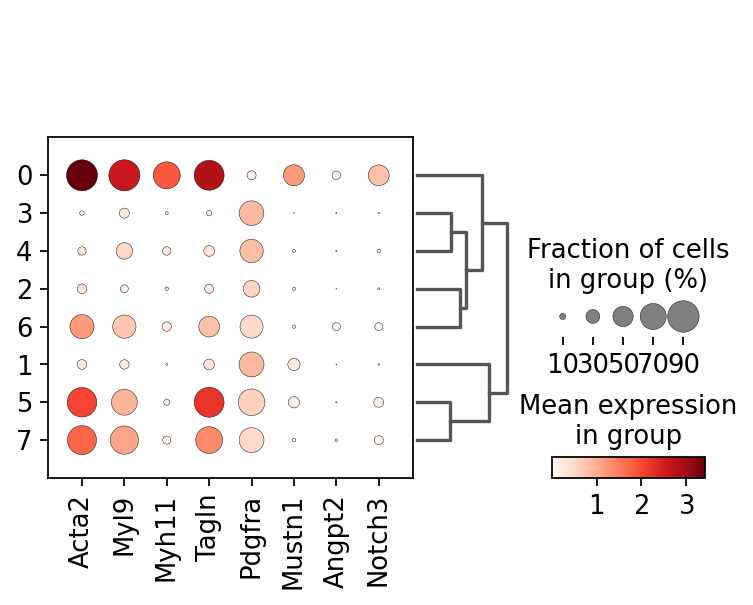

In [67]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3'], save = 'c0_mouse.png')

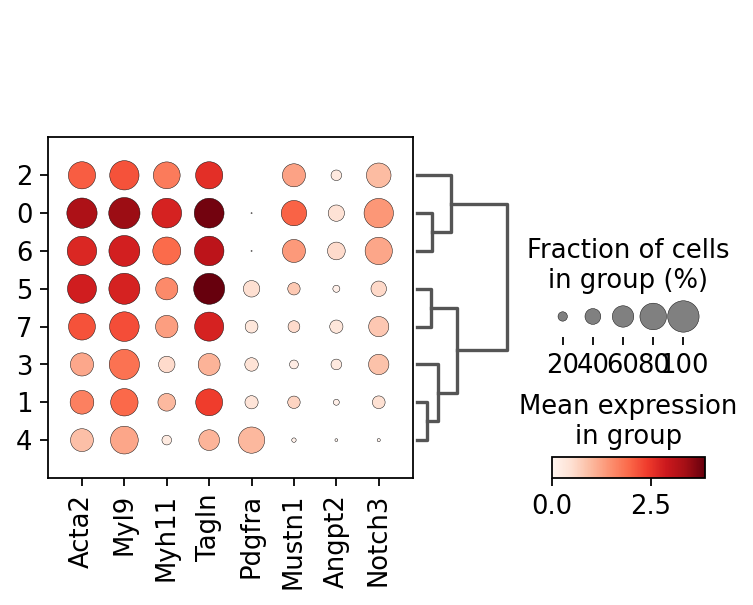

In [164]:
sc.pl.rank_genes_groups_dotplot(adata_human, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3'], save = 'c0_human.png')

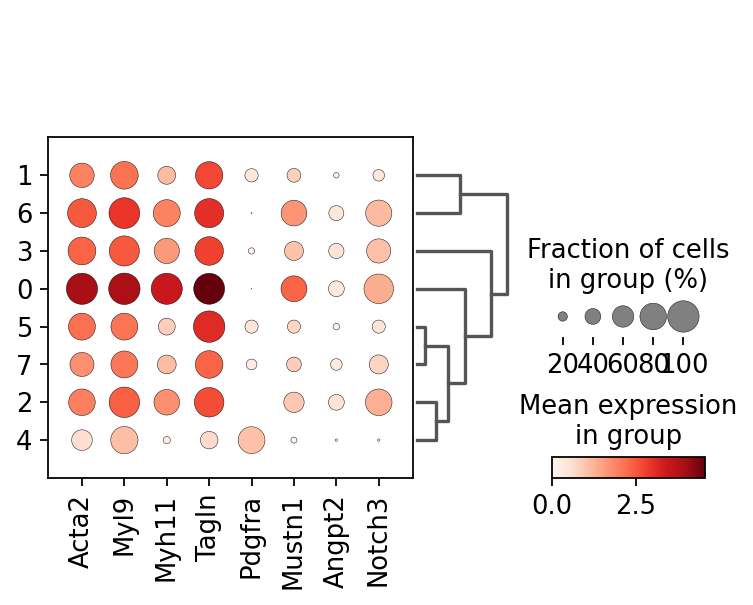

In [68]:
sc.pl.rank_genes_groups_dotplot(adata_human_new, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3'], save = 'c0_human.png')

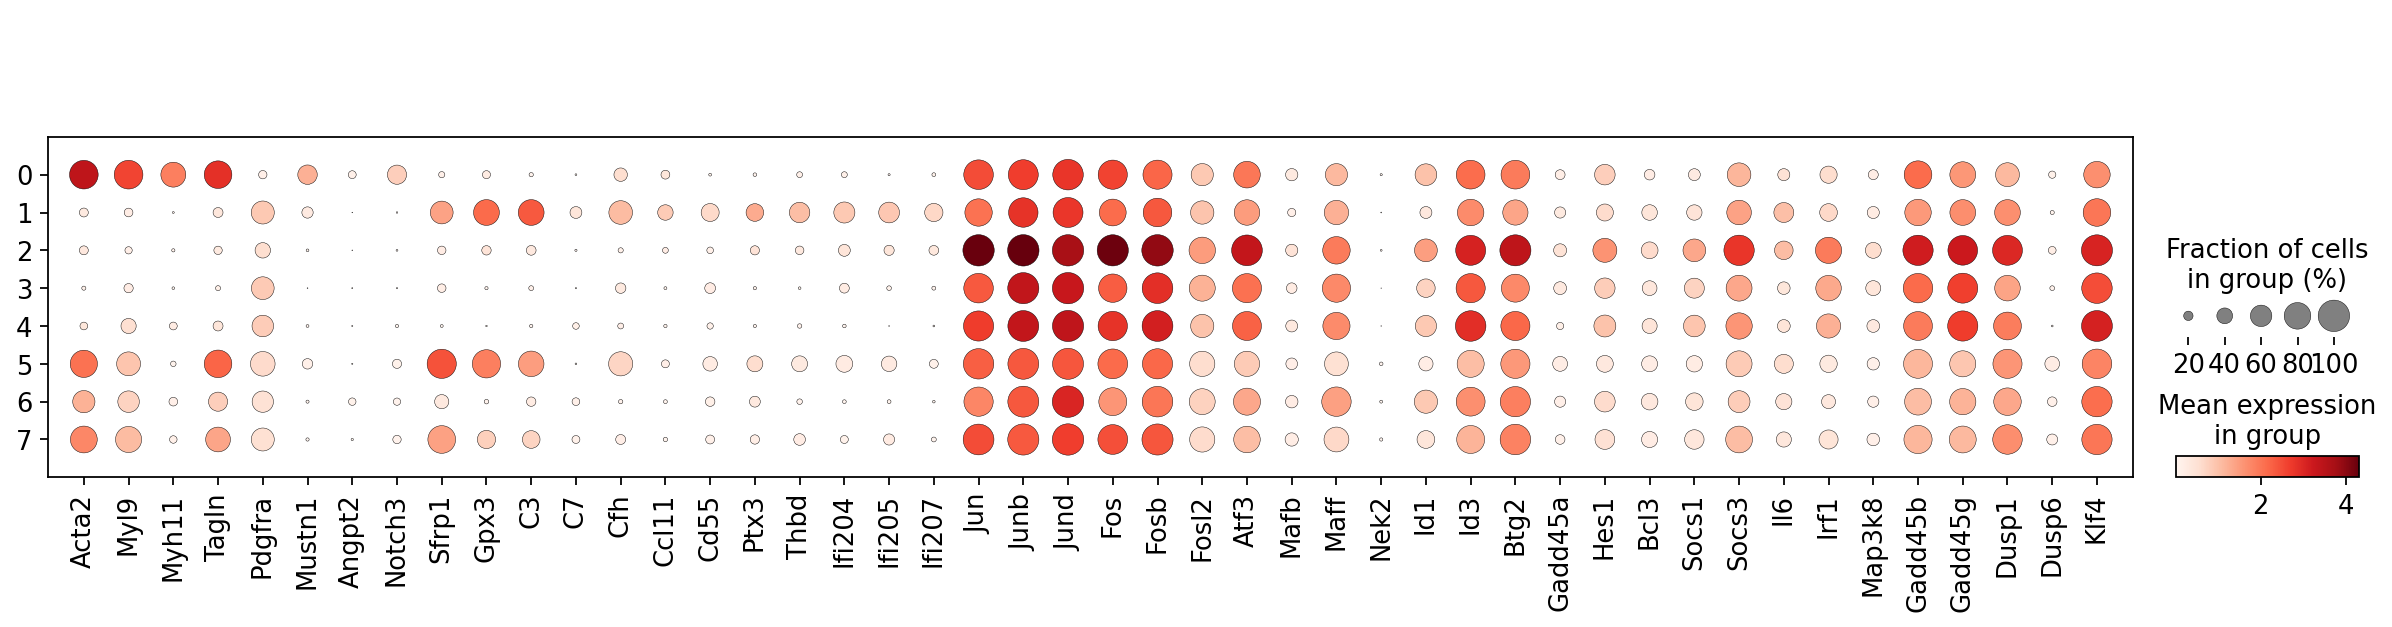

In [70]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3', 'Sfrp1', 'Gpx3', 'C3', 'C7', 'Cfh', 'Ccl11', 'Cd55', 'Ptx3', 'Thbd', 'Ifi204', 'Ifi205', 'Ifi207', 'Jun', 'Junb', 'Jund', 'Fos', 'Fosb', 'Fosl2', 'Atf3', 'Mafb', 'Maff', 'Nek2', 'Id1', 'Id3', 'Btg2', 'Gadd45a', 'Hes1', 'Bcl3', 'Socs1', 'Socs3', 'Il6', 'Irf1', 'Map3k8', 'Gadd45b', 'Gadd45g', 'Dusp1', 'Dusp6', 'Klf4'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'mouse.png')


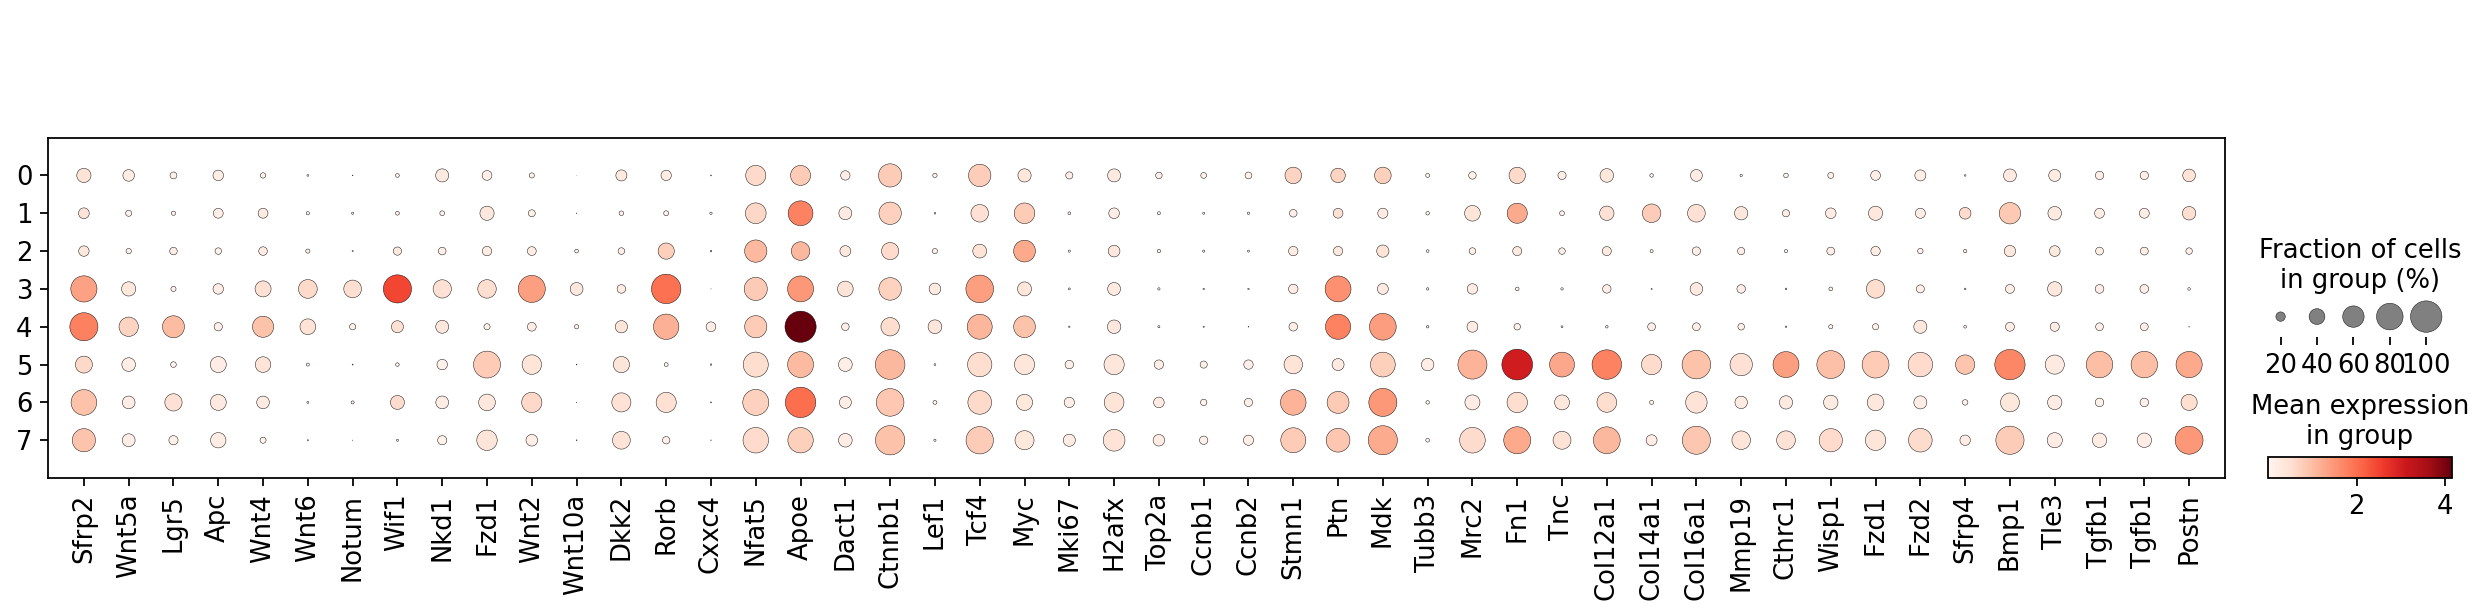

In [71]:
sc.pl.rank_genes_groups_dotplot(adata_mouse, var_names = ['Sfrp2', 'Wnt5a', 'Lgr5', 'Apc', 'Wnt4', 'Wnt6', 'Notum', 'Wif1', 'Nkd1', 'Fzd1', 'Wnt2', 'Wnt10a', 'Dkk2', 'Rorb', 'Cxxc4', 'Nfat5', 'Apoe', 'Dact1', 'Ctnnb1', 'Lef1', 'Tcf4', 'Myc', 'Mki67', 'H2afx', 'Top2a', 'Ccnb1', 'Ccnb2', 'Stmn1', 'Ptn', 'Mdk', 'Tubb3', 'Mrc2', 'Fn1', 'Tnc', 'Col12a1', 'Col14a1', 'Col16a1', 'Mmp19', 'Cthrc1', 'Wisp1', 'Fzd1', 'Fzd2', 'Sfrp4', 'Bmp1', 'Tle3', 'Tgfb1', 'Tgfb1', 'Postn'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'mouse2.png')


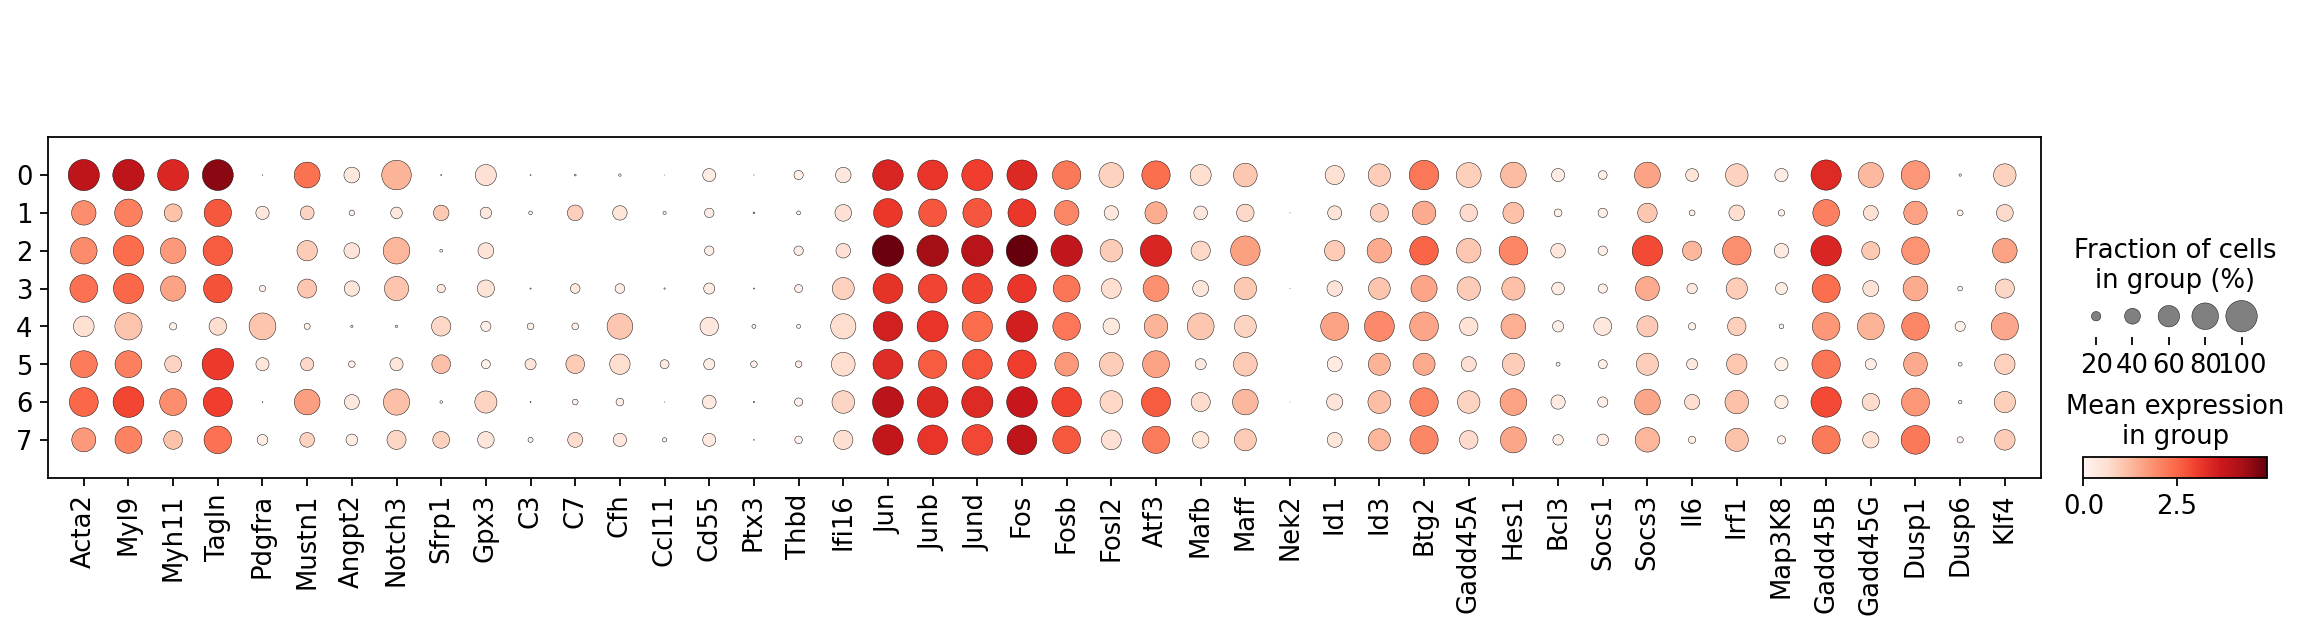

In [72]:
sc.pl.rank_genes_groups_dotplot(adata_human_new, var_names = ['Acta2', 'Myl9', 'Myh11', 'Tagln', 'Pdgfra', 'Mustn1', 'Angpt2', 'Notch3', 'Sfrp1', 'Gpx3', 'C3', 'C7', 'Cfh', 'Ccl11', 'Cd55', 'Ptx3', 'Thbd', 'Ifi16', 'Jun', 'Junb', 'Jund', 'Fos', 'Fosb', 'Fosl2', 'Atf3', 'Mafb', 'Maff', 'Nek2', 'Id1', 'Id3', 'Btg2', 'Gadd45A', 'Hes1', 'Bcl3', 'Socs1', 'Socs3', 'Il6', 'Irf1', 'Map3K8', 'Gadd45B', 'Gadd45G', 'Dusp1', 'Dusp6', 'Klf4'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'human.png')


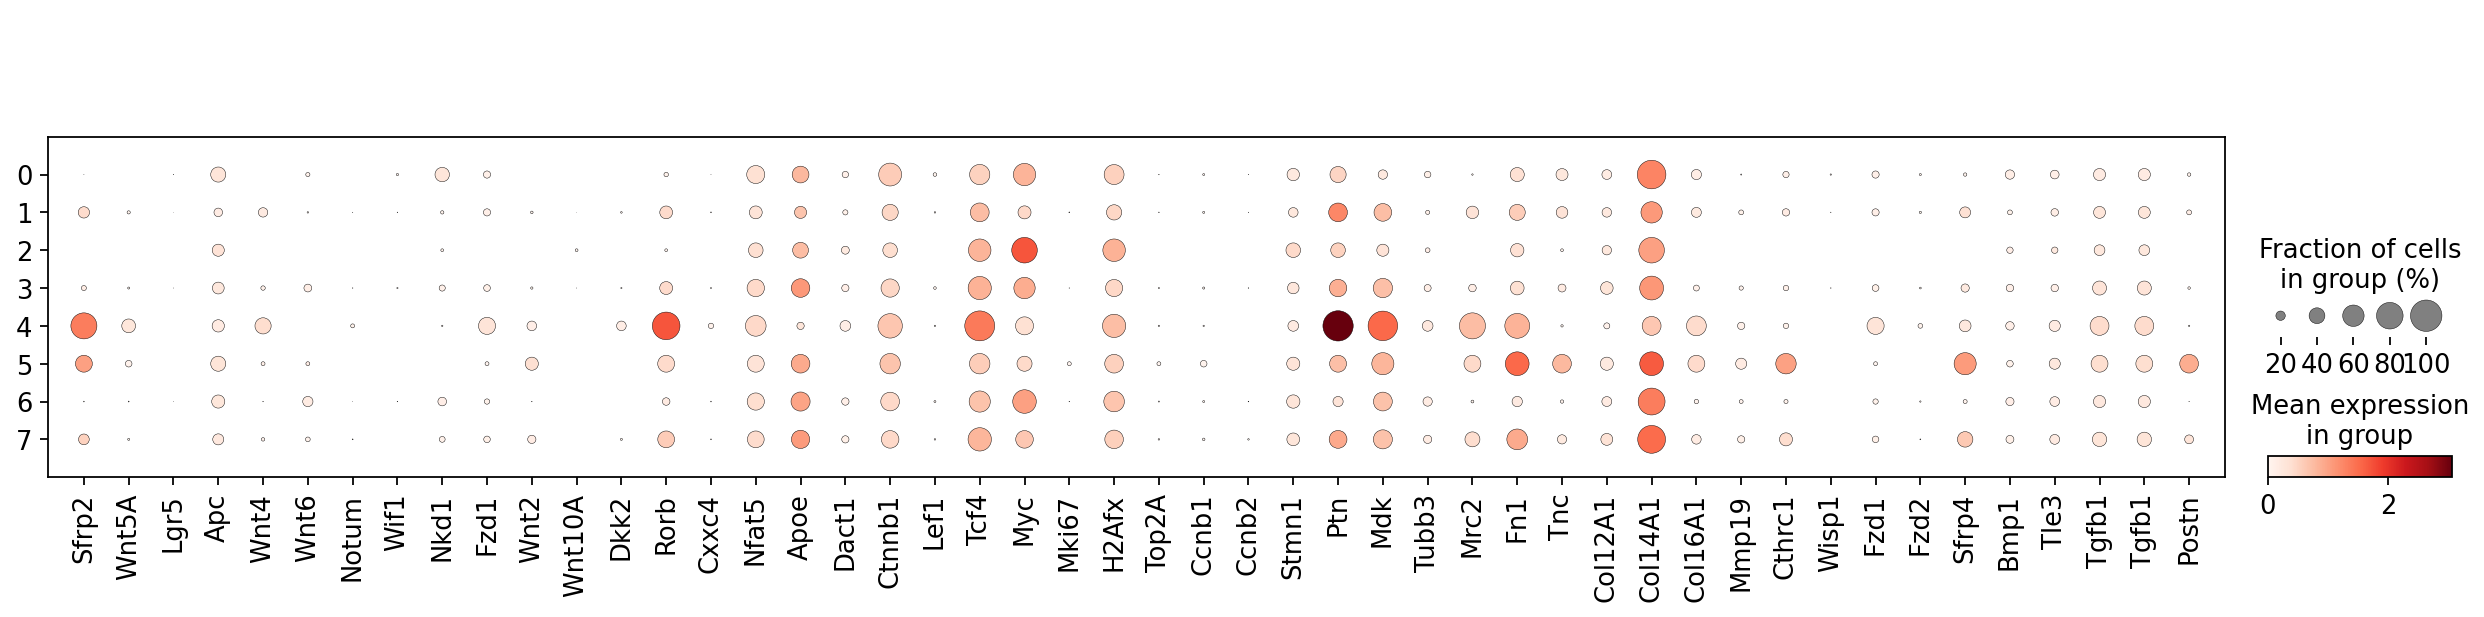

In [74]:
sc.pl.rank_genes_groups_dotplot(adata_human_new, var_names = ['Sfrp2', 'Wnt5A', 'Lgr5', 'Apc', 'Wnt4', 'Wnt6', 'Notum', 'Wif1', 'Nkd1', 'Fzd1', 'Wnt2', 'Wnt10A', 'Dkk2', 'Rorb', 'Cxxc4', 'Nfat5', 'Apoe', 'Dact1', 'Ctnnb1', 'Lef1', 'Tcf4', 'Myc', 'Mki67', 'H2Afx', 'Top2A', 'Ccnb1', 'Ccnb2', 'Stmn1', 'Ptn', 'Mdk', 'Tubb3', 'Mrc2', 'Fn1', 'Tnc', 'Col12A1', 'Col14A1', 'Col16A1', 'Mmp19', 'Cthrc1', 'Wisp1', 'Fzd1', 'Fzd2', 'Sfrp4', 'Bmp1', 'Tle3', 'Tgfb1', 'Tgfb1', 'Postn'], categories_order = ['0','1','2','3','4','5','6','7'], dendrogram = False, save = 'human2.png')


# save the normalized human data (not z-scored) for cellchat

In [75]:
adata_human_raw = adata_human.raw.to_adata()
adata_human_raw.X = sp.csr_matrix.todense(adata_human_raw.X)
adata_human_raw.X = adata_human_raw.to_df()
adata_human_raw.write('outs/forCellChat/adata_human_norm.h5ad')

# get the differentially expressed genes (human)

In [44]:
sc.tl.rank_genes_groups(adata_human_new, 'cluster', method='t-test')
markers_human_c0 = sc.get.rank_genes_groups_df(adata_human_new, group = '0')
markers_human_c1 = sc.get.rank_genes_groups_df(adata_human_new, group = '1')
markers_human_c2 = sc.get.rank_genes_groups_df(adata_human_new, group = '2')
markers_human_c3 = sc.get.rank_genes_groups_df(adata_human_new, group = '3')
markers_human_c4 = sc.get.rank_genes_groups_df(adata_human_new, group = '4')
markers_human_c5 = sc.get.rank_genes_groups_df(adata_human_new, group = '5')
markers_human_c6 = sc.get.rank_genes_groups_df(adata_human_new, group = '6')
markers_human_c7 = sc.get.rank_genes_groups_df(adata_human_new, group = '7')

In [32]:
markers_human.columns

Index(['group', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj'], dtype='object')

In [42]:
#markers_human_c0.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c1.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c2.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c3.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c4.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c5.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c6.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)
#markers_human_c7.sort_values(by = ['logfoldchanges'], inplace=True, ascending = False)

In [45]:
markers_human_c0.to_csv('markers_human_c0.csv')
markers_human_c1.to_csv('markers_human_c1.csv')
markers_human_c2.to_csv('markers_human_c2.csv')
markers_human_c3.to_csv('markers_human_c3.csv')
markers_human_c4.to_csv('markers_human_c4.csv')
markers_human_c5.to_csv('markers_human_c5.csv')
markers_human_c6.to_csv('markers_human_c6.csv')
markers_human_c7.to_csv('markers_human_c7.csv')

###############